In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as random
import jax.scipy as jsp
from minigp.gp import *
from minigp.kernel import DeepKernelParameters, DeepKernel
from minigp.utils import *

In [2]:
def warp(x: float) -> float:
    segment1 = 2 * jnp.pi
    segment2 = 10 * jnp.pi
    max_x = 12 * jnp.pi

    warped_segment1 = 16 * jnp.pi
    warped_segment2 = 18 * jnp.pi
    max_warped = 34 * jnp.pi
    
    piece1 = min(segment1, x)
    piece2 = max(0, x - segment1)
    piece2 = min(piece2, segment2 - segment1)
    piece3 = max(0, x - segment2)
    piece3 = min(piece3, max_x - segment2)
    
    return piece1 * (warped_segment1 / segment1) + piece2 * ((warped_segment2 - warped_segment1) / (segment2 - segment1)) + piece3 * ((max_warped - warped_segment2) / (max_x - segment2))

warp_vec = np.vectorize(warp)

def warped_sine(x: jnp.ndarray) -> jnp.ndarray:
    """Compute sine of the warped input."""
    warped_x = x
    warped_x = warp_vec(x)
    return jnp.sin(warped_x)

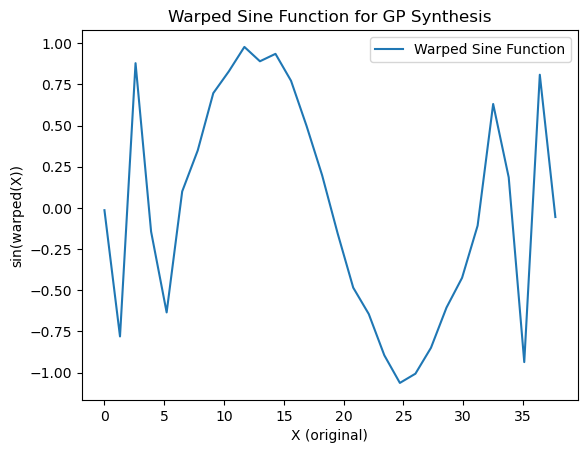

In [3]:
X_train = jnp.linspace(0, 12 * jnp.pi, 30).reshape(-1, 1)
y_train = warped_sine(X_train.flatten()) + 0.05 * random.normal(jax.random.PRNGKey(0), (30,))

X_np = np.array(X_train)
y_np = np.array(y_train)

# Plot the warped sine function
plt.plot(X_np, y_np, label="Warped Sine Function")
plt.title("Warped Sine Function for GP Synthesis")
plt.xlabel("X (original)")
plt.ylabel("sin(warped(X))")
plt.legend()
plt.show()

In [4]:
key = jax.random.PRNGKey(123)
kernel = GaussianKernel()
kernel_params = kernel.init_params(key)

gp = GaussianProcess()
state, gp_params = gp.init_state_with_params(kernel, kernel_params, X_train, y_train)

In [5]:
optimized_kernel_params, optimized_gp_params = optimize_mle(gp, state, kernel_params, gp_params, num_iters= 200, learning_rate = 0.01)
state, gp_params = gp.fit(state, optimized_kernel_params, optimized_gp_params)

Iteration 50, Loss: 511.9583
Iteration 100, Loss: 344.8922
Iteration 150, Loss: 249.4023
Iteration 200, Loss: 189.7776


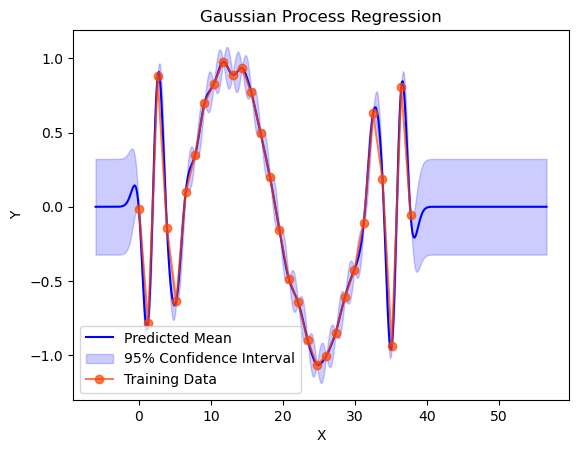

In [6]:
X_test = jnp.linspace(-6, 18 * jnp.pi, 500).reshape(-1, 1)
y_true = warped_sine(X_test.flatten())
mu_s, cov_s = gp.predict(state, optimized_kernel_params, gp_params, X_test)
std_s = jnp.sqrt(cov_s)
plot_process(X_train, y_train, X_test, mu_s, std_s)

In [7]:
print(optimized_kernel_params)
print(optimized_gp_params)

GaussianKernelParameters(log_alpha=Array(-3.608732, dtype=float32), sigma=Array(0.783728, dtype=float32))
GaussianProcessParameters(noise=Array(-12.70122, dtype=float32))


In [8]:
kernel = HeightKernel(3)
kernel_params = kernel.init_params(key)

gp = GaussianProcess()
state, gp_params = gp.init_state_with_params(kernel, kernel_params, X_train, y_train)

In [9]:
optimized_kernel_params, optimized_gp_params = optimize_mle(gp, state, kernel_params, gp_params, num_iters= 1000, learning_rate = 0.05)
state, gp_params = gp.fit(state, optimized_kernel_params, optimized_gp_params)

Iteration 50, Loss: 649.0569
Iteration 100, Loss: 571.1675
Iteration 150, Loss: 499.3423
Iteration 200, Loss: 434.0338
Iteration 250, Loss: 377.4766
Iteration 300, Loss: 329.5487
Iteration 350, Loss: 289.2656
Iteration 400, Loss: 255.4499
Iteration 450, Loss: 226.9947
Iteration 500, Loss: 202.9481
Iteration 550, Loss: 182.5215
Iteration 600, Loss: 165.0749
Iteration 650, Loss: 150.0907
Iteration 700, Loss: 137.1522
Iteration 750, Loss: 125.9223
Iteration 800, Loss: 116.1284
Iteration 850, Loss: 107.5477
Iteration 900, Loss: 99.9981
Iteration 950, Loss: 93.3292
Iteration 1000, Loss: 87.4168


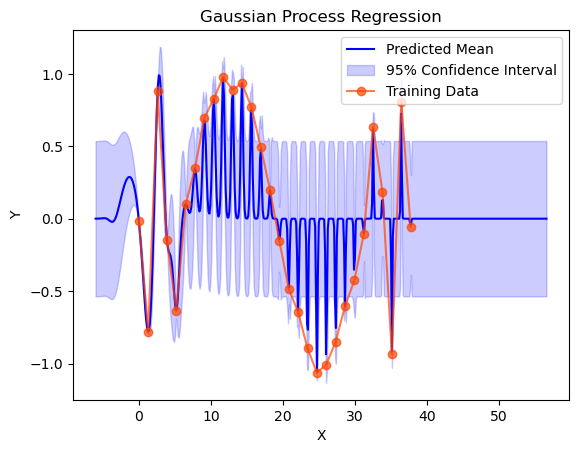

In [10]:
X_test = jnp.linspace(-6, 18 * jnp.pi, 500).reshape(-1, 1)
y_true = warped_sine(X_test.flatten())
mu_s, cov_s = gp.predict(state, optimized_kernel_params, gp_params, X_test)
std_s = jnp.sqrt(cov_s)
plot_process(X_train, y_train, X_test, mu_s, std_s)

In [11]:
print(optimized_kernel_params)
print(optimized_gp_params)

HeightKernelParameters(log_alpha=Array(-2.5918934, dtype=float32), sigma=Array(2.3924835, dtype=float32), coef=Array([0.15782227, 0.8417088 , 0.4781423 ], dtype=float32))
GaussianProcessParameters(noise=Array(-13.436147, dtype=float32))
